<a href="https://colab.research.google.com/github/acastillo5248/Machine_Learning_Finance_Final_Project/blob/main/MLF_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from statsmodels.formula.api import ols
from scipy.stats import gaussian_kde
import scipy
import scipy.sparse
import patsy
from statistics import median
import bz2
import math

In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
model_dir = '/content/drive/MyDrive/Senior/FACTOR_MODEL/'
def sort_cols(test):
  return(test.reindex(sorted(test.columns), axis=1))
frames = {}
for year in [2004,2005,2006]:
  fil = model_dir + "pandas-frames." + str(year) + ".pickle.bz2"
  frames.update(pd.read_pickle(fil))
for x in frames:
  frames[x] = sort_cols(frames[x])
covariance = {}
for year in [2003,2004,2005,2006]:
  fil = model_dir + "covariance." + str(year) + ".pickle.bz2"
  covariance.update(pd.read_pickle(fil))

In [ ]:
industry_factors = ['AERODEF', 'AIRLINES', 'ALUMSTEL', 'APPAREL', 'AUTO',
'BANKS','BEVTOB', 'BIOLIFE', 'BLDGPROD','CHEM', 'CNSTENG',
'CNSTMACH', 'CNSTMATL', 'COMMEQP', 'COMPELEC',
'COMSVCS', 'CONGLOM', 'CONTAINR', 'DISTRIB',
'DIVFIN', 'ELECEQP', 'ELECUTIL', 'FOODPROD', 'FOODRET', 'GASUTIL',
'HLTHEQP', 'HLTHSVCS', 'HOMEBLDG', 'HOUSEDUR','INDMACH', 'INSURNCE',
'INTERNET',
'LEISPROD', 'LEISSVCS', 'LIFEINS', 'MEDIA', 'MGDHLTH','MULTUTIL',
'OILGSCON', 'OILGSDRL', 'OILGSEQP', 'OILGSEXP',
'PAPER', 'PHARMA', 'PRECMTLS','PSNLPROD','REALEST',
'RESTAUR', 'ROADRAIL','SEMICOND', 'SEMIEQP','SOFTWARE',
'SPLTYRET', 'SPTYCHEM', 'SPTYSTOR', 'TELECOM', 'TRADECO', 'TRANSPRT',
'WIRELESS']
style_factors = ['BETA','SIZE','MOMENTUM','VALUE','LEVERAGE','LIQUIDTY']

In [ ]:
def wins(x,a,b):
  return(np.where(x <= a,a, np.where(x >= b, b, x)))
def clean_nas(df):
  numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
  for numeric_column in numeric_columns:
    df[numeric_column] = np.nan_to_num(df[numeric_column])
  return df

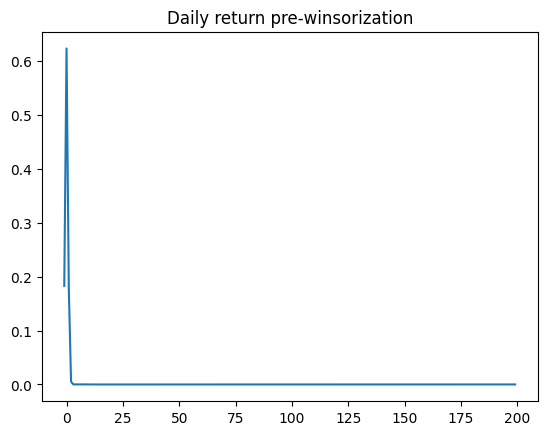

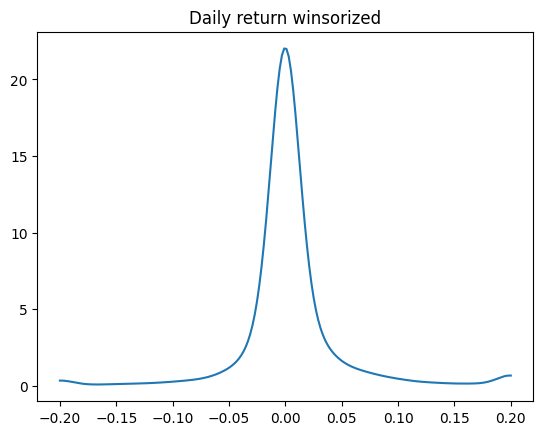

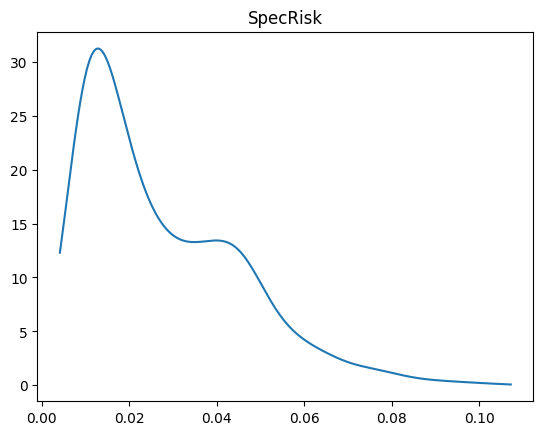

In [ ]:
def density_plot(data, title):
  density = gaussian_kde(data)
  xs = np.linspace(np.min(data),np.max(data),200)
  density.covariance_factor = lambda : .25
  density._compute_covariance()
  plt.plot(xs,density(xs))
  plt.title(title)
  plt.show()
test = frames['20040102']
density_plot(test['Ret'], 'Daily return pre-winsorization')
density_plot(wins(test['Ret'],-0.2,0.2), 'Daily return winsorized')
D = (test['SpecRisk'] / (100 * math.sqrt(252))) ** 2
density_plot(np.sqrt(D), 'SpecRisk')

In [ ]:
def get_estu(df):
  """Estimation universe definition"""
  estu = df.loc[df.IssuerMarketCap > 1e9].copy(deep=True)
  return estu
def colnames(X):
  """ return names of columns, for DataFrame or DesignMatrix """
  if(type(X) == patsy.design_info.DesignMatrix):
    return(X.design_info.column_names)
  if(type(X) == pandas.core.frame.DataFrame):
    return(X.columns.tolist())
  return(None)
def diagonal_factor_cov(date, X):
  """Factor covariance matrix, ignoring off-diagonal for simplicity"""
  cv = covariance[date]
  k = np.shape(X)[1]
  Fm = np.zeros([k,k])
  for j in range(0,k):
    fac = colnames(X)[j]
    Fm[j,j] = (0.01**2) * cv.loc[(cv.Factor1==fac) & (cv.Factor2==fac),"VarCovar"].iloc[0]
  return(Fm)
def risk_exposures(estu):
  """Exposure matrix for risk factors, usually called X in class"""
  L = ["0"]
  L.extend(style_factors)
  L.extend(industry_factors)
  my_formula = " + ".join(L)
  return patsy.dmatrix(my_formula, data = estu)

In [ ]:
my_date = '20040102'
# estu = estimation universe
estu = get_estu(frames[my_date])
estu['Ret'] = wins(estu['Ret'], -0.25, 0.25)
rske = risk_exposures(estu)
F = diagonal_factor_cov(my_date, rske)
X = np.asarray(rske)
D = np.asarray( (estu['SpecRisk'] / (100 * math.sqrt(252))) ** 2 )
kappa = 1e-5
candidate_alphas = [
'STREVRSL', 'LTREVRSL', 'INDMOM',
'EARNQLTY', 'EARNYILD', 'MGMTQLTY', 'PROFIT', 'SEASON', 'SENTMT']

In [ ]:
F, X, D

(array([[0.00348478, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.00061952, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.00042807, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00521378, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.00726435,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.02185539]]),
 array([[-2.177,  0.858, -0.73 , ...,  0.   ,  0.   ,  0.   ],
        [-2.045,  0.858, -1.707, ...,  0.   ,  0.   ,  0.   ],
        [-0.948, -1.888,  0.535, ...,  0.   ,  0.   ,  0.   ],
        ...,
        [-2.053,  0.858, -0.458, ...,  0.   ,  0.   ,  0.   ],
        [-2.022,  0.858, -0.321, ...,  0.   ,  0.   ,  0.   ],
        [-1.985, -0.785, -0.144, ...,  0.   ,  0.   ,  0.   ]]),
 array([3.224654

# Problem 0

In [ ]:
# problem 0

for date in frames.keys():
    estu = get_estu(frames[date])
    rske = risk_exposures(estu)
    rske_indices = rske.design_info.column_names
    estu = estu.iloc[:len(rske_indices),:]

frames['20040102']

,1DREVRSL,AERODEF,AIRLINES,ALUMSTEL,APPAREL,AUTO,BANKS,BETA,BEVTOB,BIOLIFE,...,SPTYSTOR,STREVRSL,SpecRisk,TELECOM,TRADECO,TRANSPRT,TotalRisk,VALUE,WIRELESS,Yield
0,-0.032,0.0,0.0,0.0,0.0,0.0,0.00,-2.177,0.0,0.0,...,0.0,0.548,9.014505,0.054,0.0,0.0,13.959397,0.644,0.0,0.188679
1,0.684,0.0,0.0,0.0,0.0,0.0,0.00,-2.045,0.0,0.0,...,0.0,0.986,19.304651,0.000,0.0,0.0,23.393503,-0.700,0.0,3.203463
2,0.235,0.0,0.0,0.0,0.0,0.0,0.00,-2.010,0.0,0.0,...,0.0,-0.256,19.802556,0.000,0.0,0.0,22.135724,0.513,0.0,1.290796
3,0.759,0.0,0.0,0.0,0.0,0.0,0.00,-0.948,0.0,0.0,...,0.0,1.841,31.274403,0.000,0.0,0.0,35.785120,0.609,0.0,NaN
4,0.674,0.0,0.0,0.0,0.0,0.0,0.00,-2.148,0.0,0.0,...,0.0,-0.588,13.533480,0.000,0.0,0.0,18.928129,2.986,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12430,-0.953,0.0,0.0,0.0,0.0,0.0,0.97,-2.009,0.0,0.0,...,0.0,0.430,9.095567,0.000,0.0,0.0,13.125982,0.928,0.0,2.770352
12431,-0.808,0.0,0.0,0.0,0.0,0.0,0.97,-2.066,0.0,0.0,...,0.0,0.561,8.739695,0.000,0.0,0.0,12.888183,0.966,0.0,7.175297
12432,-0.754,0.0,0.0,0.0,0.0,0.0,0.97,-2.053,0.0,0.0,...,0.0,0.734,9.565838,0.000,0.0,0.0,13.436052,0.818,0.0,2.770352
12433,-0.647,0.0,0.0,0.0,0.0,0.0,0.97,-2.022,0.0,0.0,...,0.0,0.680,9.394557,0.000,0.0,0.0,13.256003,0.774,0.0,2.770352


# Problem 1

In [ ]:
# problem 1

def residual_returns(frames):
  for date, frame in frames.items():
    print(date)
    estu = get_estu(frame)

    rske = risk_exposures(estu)
    X = np.asarray(rske)

    X_pseudoinverse = np.linalg.pinv(X)

    print(X_pseudoinverse.shape)
    print(estu['Ret'].shape)

    np.dot(X_pseudoinverse, estu['Ret'])

    dot = np.dot(X, np.dot(X_pseudoinverse, estu['Ret']))

    estu['Y'] = estu['Ret'] - np.dot(X, np.dot(X_pseudoinverse, estu['Ret']))

    frames[date] = estu

residual_returns(frames)



20040102
(65, 2265)
(2265,)
20040105
(65, 2284)
(2284,)
20040106
(65, 2284)
(2284,)
20040107
(65, 2288)
(2288,)
20040108
(65, 2299)
(2299,)
20040109
(65, 2297)
(2297,)
20040112
(65, 2309)
(2309,)
20040113
(65, 2301)
(2301,)
20040114
(65, 2309)
(2309,)
20040115
(65, 2304)
(2304,)
20040116
(65, 2311)
(2311,)
20040120
(65, 2333)
(2333,)
20040121
(65, 2325)
(2325,)
20040122
(65, 2324)
(2324,)
20040123
(65, 2330)
(2330,)
20040126
(65, 2335)
(2335,)
20040127
(65, 2326)
(2326,)
20040128
(65, 2312)
(2312,)
20040129
(65, 2298)
(2298,)
20040130
(65, 2295)
(2295,)
20040202
(65, 2299)
(2299,)
20040203
(65, 2294)
(2294,)
20040204
(65, 2279)
(2279,)
20040205
(65, 2289)
(2289,)
20040206
(65, 2305)
(2305,)
20040209
(65, 2310)
(2310,)
20040210
(65, 2318)
(2318,)
20040211
(65, 2324)
(2324,)
20040212
(65, 2324)
(2324,)
20040213
(65, 2318)
(2318,)
20040217
(65, 2328)
(2328,)
20040218
(65, 2326)
(2326,)
20040219
(65, 2314)
(2314,)
20040220
(65, 2307)
(2307,)
20040223
(65, 2294)
(2294,)
20040224
(65, 2303)


# Problem 2

In [ ]:
# Split into train/validation and test sets based on dates making sure to not split within a single day
train_dates = [date for date in frames.keys() if int(date) < 20060101]
test_dates = [date for date in frames.keys() if int(date) >= 20060101]

# Combine frames for train and test
train_frames = pd.concat([frames[date] for date in train_dates])
test_frames = pd.concat([frames[date] for date in test_dates])

# Define features (candidate alphas) and target (residual return 'Y')
candidate_alphas = ['STREVRSL', 'LTREVRSL', 'INDMOM', 'EARNQLTY', 'EARNYILD',
                    'MGMTQLTY', 'PROFIT', 'SEASON', 'SENTMT']
X_train = train_frames[candidate_alphas]
y_train = train_frames['Y']
X_test = test_frames[candidate_alphas]
y_test = test_frames['Y']


In [ ]:
# using elastic net as our linear model

from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error

# train Elastic Net with cross-validation
elastic_net = ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.9], random_state=42)
elastic_net.fit(X_train, y_train)

# evaluate on the test set
y_pred_elastic = elastic_net.predict(X_test)
mse_elastic = mean_squared_error(y_test, y_pred_elastic)

print("Elastic Net MSE:", mse_elastic)


Elastic Net MSE: 0.00041110076214547674


In [ ]:
# using a neural network as our non-linear model

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # single output for residual returns
])


nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
nn_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100,
             batch_size=32, callbacks=[early_stopping], verbose=1)


y_pred_nn = nn_model.predict(X_test_scaled)
mse_nn = mean_squared_error(y_test, y_pred_nn)

print("Neural Network MSE:", mse_nn)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30592/30592 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - loss: 0.0020 - val_loss: 4.2374e-04
Epoch 2/100
 8430/30592 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - loss: 0.0017

KeyboardInterrupt: 

# Problem 3

In [ ]:
def woodbury_portfolio(mu, X, F, D, kappa):
    D_inv = np.diag(1 / np.diag(D))

    X_t_D_inv = np.dot(X.T, D_inv)  # X^T D^-1
    middle_matrix = np.linalg.inv(F + np.dot(X_t_D_inv, X))  # (F + X^T D^-1 X)^-1

    Sigma_inv = D_inv - np.dot(D_inv, np.dot(X, np.dot(middle_matrix, X_t_D_inv)))

    h = np.dot(Sigma_inv, mu) / kappa
    return h



# Problem 4

In [ ]:
def backtest_portfolio_with_model(frames, model, kappa=1e-5):
    """
    Backtest portfolio optimization using model-predicted factor returns.

    Parameters:
    - frames: Dictionary of data frames (key = date, value = DataFrame)
    - model: Trained model (Elastic Net or Neural Network)
    - kappa: Risk aversion parameter (float)

    Returns:
    - results: Dictionary with time-series data for cumulative profit, risk, and market values.
    """
    cumulative_profit = []
    daily_risk = []
    idiosyncratic_risk_percent = []
    long_market_values = []
    short_market_values = []

    # Initialize profit
    cumulative_profit_value = 0

    # Iterate through each date
    for date, frame in frames.items():
        estu = get_estu(frame)
        rske = risk_exposures(estu)
        X = np.asarray(rske, dtype=np.float32)  # Ensure X is a NumPy array with the correct dtype
        F = diagonal_factor_cov(date, rske)  # Factor covariance matrix
        D = np.diag((estu['SpecRisk'] / (100 * np.sqrt(252))) ** 2)  # Idiosyncratic risk matrix

        # Debug shapes
        print(f"Date: {date}")
        print("X shape:", X.shape)

        try:
            # Predict factor returns using the model
            mu = model.predict(X)
            print("mu shape:", mu.shape)
        except Exception as e:
            print("Prediction Error:", e)
            raise

        # Compute portfolio weights
        weights = woodbury_portfolio(mu, X, F, D, kappa)

        # Compute daily portfolio return
        daily_return = np.dot(weights, estu['Ret'].values)
        cumulative_profit_value += daily_return
        cumulative_profit.append(cumulative_profit_value)

        # Compute risk metrics
        total_risk = np.dot(weights.T, np.dot(F + D, weights))  # Total risk
        idiosyncratic_risk = np.dot(weights.T, np.dot(D, weights))  # Idiosyncratic risk
        daily_risk.append(total_risk)
        idiosyncratic_risk_percent.append(idiosyncratic_risk / total_risk)

        # Compute market values
        long_market_value = sum(w for w in weights if w > 0)
        short_market_value = sum(w for w in weights if w < 0)
        long_market_values.append(long_market_value)
        short_market_values.append(short_market_value)

    # Package results
    results = {
        "cumulative_profit": cumulative_profit,
        "daily_risk": daily_risk,
        "idiosyncratic_risk_percent": idiosyncratic_risk_percent,
        "long_market_values": long_market_values,
        "short_market_values": short_market_values
    }

    return results


In [ ]:
import matplotlib.pyplot as plt

def plot_results(results):
    """
    Plot backtesting results.

    Parameters:
    - results: Dictionary with time-series data.
        Keys:
            - cumulative_profit
            - daily_risk
            - idiosyncratic_risk_percent
            - long_market_values
            - short_market_values
    """
    # Extract data
    dates = range(len(results["cumulative_profit"]))  # Index to represent dates
    cumulative_profit = results["cumulative_profit"]
    daily_risk = results["daily_risk"]
    idiosyncratic_risk_percent = results["idiosyncratic_risk_percent"]
    long_market_values = results["long_market_values"]
    short_market_values = results["short_market_values"]

    # Plot Cumulative Profit
    plt.figure(figsize=(10, 6))
    plt.plot(dates, cumulative_profit, label="Cumulative Profit", color="blue")
    plt.title("Cumulative Profit Over Time")
    plt.xlabel("Time (Days)")
    plt.ylabel("Cumulative Profit")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Daily Risk
    plt.figure(figsize=(10, 6))
    plt.plot(dates, daily_risk, label="Daily Risk", color="red")
    plt.title("Daily Portfolio Risk")
    plt.xlabel("Time (Days)")
    plt.ylabel("Risk")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Percent of Risk That is Idiosyncratic
    plt.figure(figsize=(10, 6))
    plt.plot(dates, idiosyncratic_risk_percent, label="Idiosyncratic Risk (%)", color="green")
    plt.title("Percentage of Risk That is Idiosyncratic")
    plt.xlabel("Time (Days)")
    plt.ylabel("Idiosyncratic Risk (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Long and Short Market Values
    plt.figure(figsize=(10, 6))
    plt.plot(dates, long_market_values, label="Long Market Value", color="purple")
    plt.plot(dates, short_market_values, label="Short Market Value", color="orange")
    plt.title("Long and Short Market Values Over Time")
    plt.xlabel("Time (Days)")
    plt.ylabel("Market Value")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# Train model from Problem 2
# Example: Elastic Net or Neural Network
trained_model = nn_model  # Replace with your actual model

# Run backtest
results = backtest_portfolio_with_model(frames, trained_model, kappa=1e-5)

# Plot results
plot_results(results)


Date: 20040102
X shape: (2265, 65)
Prediction Error: Graph execution error:

Detected at node sequential_1_1/dense_3_1/MatMul defined at (most recent call last):
<stack traces unavailable>
Matrix size-incompatible: In[0]: [32,65], In[1]: [9,64]

Stack trace for op definition: 
File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
File "/usr/lib/python3.10/asyncio/events.py", line 80,

InvalidArgumentError: Graph execution error:

Detected at node sequential_1_1/dense_3_1/MatMul defined at (most recent call last):
<stack traces unavailable>
Matrix size-incompatible: In[0]: [32,65], In[1]: [9,64]

Stack trace for op definition: 
File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
File "<ipython-input-39-9869d60daa5b>", line 6, in <cell line: 6>
File "<ipython-input-37-07b04863a25f>", line 36, in backtest_portfolio_with_model
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 512, in predict
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 208, in one_step_on_data_distributed
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 198, in one_step_on_data
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 96, in predict_step
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 212, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph
File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 560, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py", line 144, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/numpy.py", line 3445, in matmul
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/numpy.py", line 477, in matmul

	 [[{{node sequential_1_1/dense_3_1/MatMul}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_964249[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_data_distributed_964264]